In [1]:
!pip install -q pycocotools

In [2]:
import os
import torch
from PIL import Image
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import torchvision.transforms as T

class ResizeWithBBox:
    def __init__(self, size=(1080, 1080)):
        self.size = size

    def __call__(self, image, target):
        orig_w, orig_h = image.size
        new_w, new_h = self.size

        image = image.resize((new_w, new_h))

        # Ajuste das bboxes
        boxes = torch.as_tensor(target['boxes'], dtype=torch.float32)
        boxes[:, [0, 2]] *= new_w / orig_w
        boxes[:, [1, 3]] *= new_h / orig_h

        target['boxes'] = boxes
        return image, target

class COCODataset(Dataset):
    def __init__(self, img_folder, ann_file, transforms=None):
        self.coco = COCO(ann_file)
        self.img_folder = img_folder
        self.ids = list(self.coco.imgs.keys())
        self.transforms = transforms

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.img_folder, os.path.basename(img_info['file_name']))
    
        # Abrir a imagem
        img = Image.open(img_path).convert("RGB")

        # Carregar as anotações da imagem
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
    
        # Extrair bounding boxes e labels
        boxes = []
        labels = []

        for ann in anns:
            x, y, width, height = ann['bbox']
            boxes.append([x, y, x + width, y + height])
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([img_id])
        }

        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target


    def __len__(self):
        return len(self.ids)

In [3]:
from torch.utils.data import DataLoader

resize_transform = ResizeWithBBox(size=(1080, 1080))

train_dataset = COCODataset(
    img_folder='/kaggle/input/chromosome-coco-dataset/coco_dataset/images/train',
    ann_file='/kaggle/input/chromosome-coco-dataset/coco_dataset/train.json',
    transforms=resize_transform
)

val_dataset = COCODataset(
    img_folder='/kaggle/input/chromosome-coco-dataset/coco_dataset/images/val',
    ann_file='/kaggle/input/chromosome-coco-dataset/coco_dataset/val.json',
    transforms=resize_transform
)

test_dataset = COCODataset(
    img_folder='/kaggle/input/chromosome-coco-dataset/coco_dataset/images/test',
    ann_file='/kaggle/input/chromosome-coco-dataset/coco_dataset/test.json',
    transforms=resize_transform
)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
loading annotations into memory...
Done (t=0.18s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


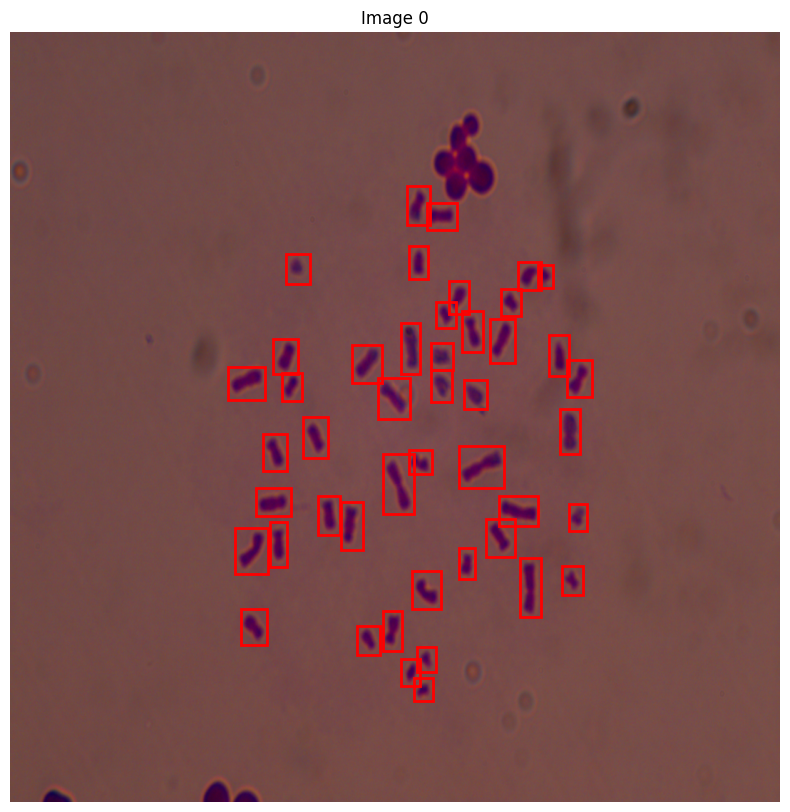

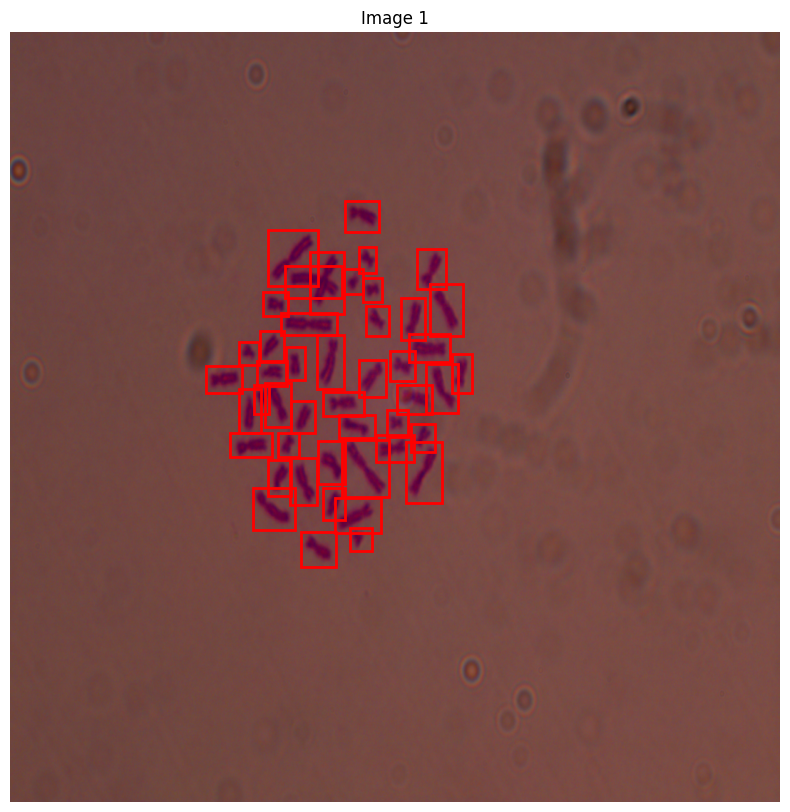

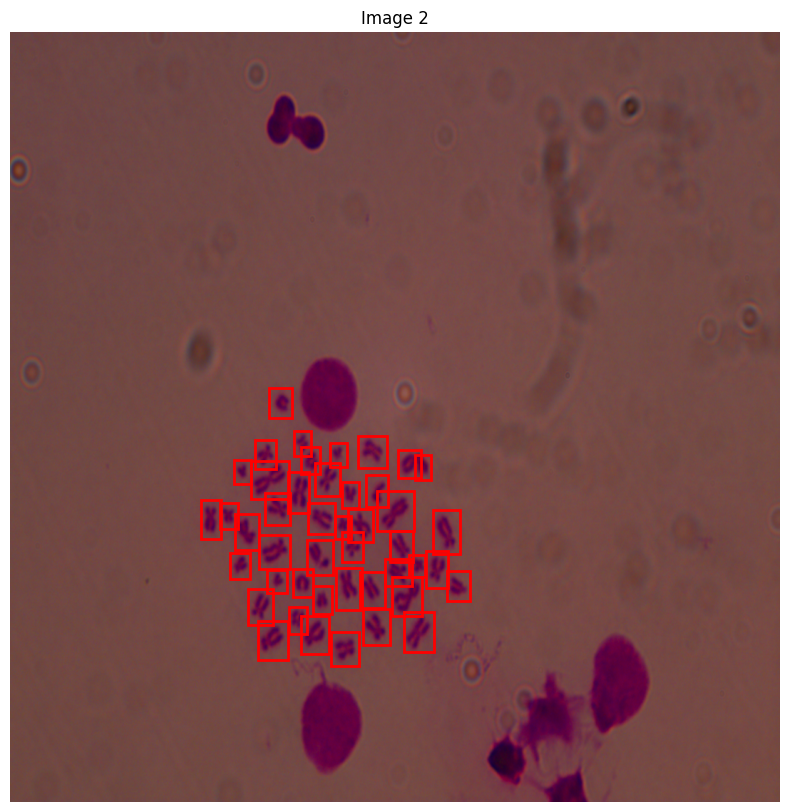

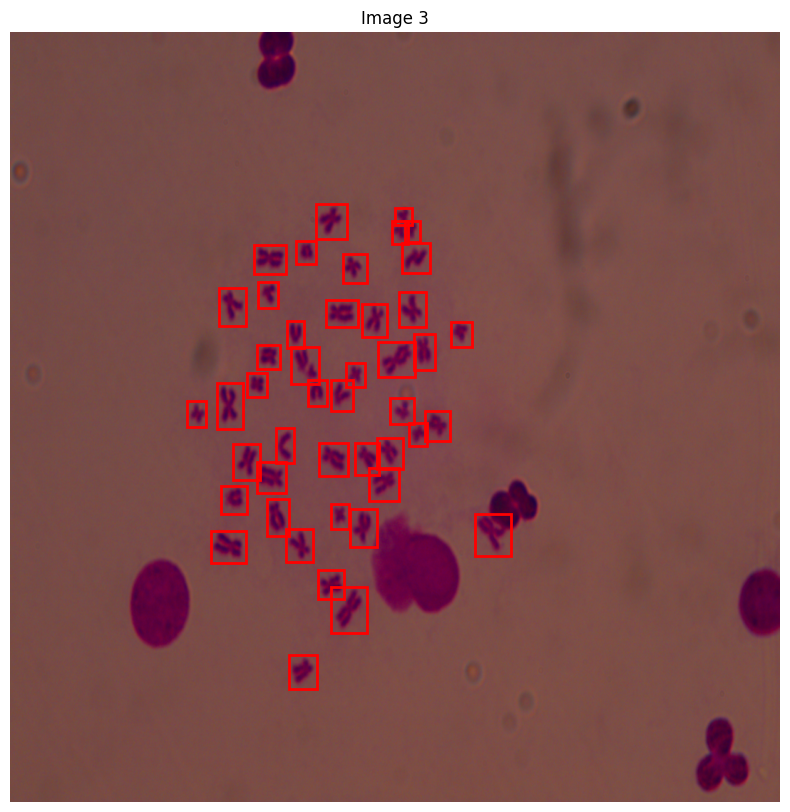

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor

def get_label_map_from_dataset(dataset):
    # Se for Subset, pega o dataset original
    base_dataset = dataset.dataset if hasattr(dataset, 'dataset') else dataset
    
    # Pega a instância COCO do dataset
    coco = getattr(base_dataset, 'coco', None)
    if coco is None:
        raise ValueError("Dataset não possui o atributo 'coco' para carregar categorias.")
    
    label_map = {
        cat['id']: cat['name']
        for cat in coco.loadCats(coco.getCatIds())
    }
    return label_map

def visualize_batch_from_loader(data_loader, label_map=None, num_images=4):
    images, targets = next(iter(data_loader))

    to_tensor = ToTensor()

    for idx in range(min(num_images, len(images))):
        img = to_tensor(images[idx]).permute(1, 2, 0).cpu().numpy()
        
        boxes = targets[idx]['boxes'].cpu()
        # labels = targets[idx]['labels'].cpu()  # Não usado porque vamos esconder os nomes

        fig, ax = plt.subplots(1, figsize=(10, 10))
        ax.imshow(img)


        for box in boxes:
            x1, y1, x2, y2 = box.tolist()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        ax.set_title(f"Image {idx}")
        plt.axis('off')
        plt.show()

label_map_train = get_label_map_from_dataset(train_dataset)
visualize_batch_from_loader(train_loader, label_map=label_map_train, num_images=4)

In [5]:
import torch
from torchvision.models.detection import (
    retinanet_resnet50_fpn,
    RetinaNet_ResNet50_FPN_Weights,
)

def get_model():
    weights = RetinaNet_ResNet50_FPN_Weights.DEFAULT
    model = retinanet_resnet50_fpn(
        weights=weights 
    )
    
    return model

num_classes = len(train_dataset.coco.getCatIds()) + 1  # inclui o background
device = "cuda" if torch.cuda.is_available() else "cpu"

model = get_model()
model.to(device)


Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_coco-eeacb38b.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_coco-eeacb38b.pth
100%|██████████| 130M/130M [00:00<00:00, 199MB/s]


RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, eps=0.0)


In [6]:
import torch
import torchvision
import time
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import StepLR

# Inicializa modelo e move para o dispositivo apropriado
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Otimizador com taxa de aprendizado inicial
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Scheduler: reduz o LR em 10× a cada 50 épocas
scheduler = StepLR(optimizer, step_size=50, gamma=0.1)

# Número total de épocas
num_epochs = 200

for epoch in range(num_epochs):
    model.train()
    for i, (images, targets) in enumerate(train_loader):
        # Converte imagens para tensor e move para o dispositivo
        images = [ToTensor()(img).to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Calcula as perdas
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Atualiza os gradientes
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Exibe as perdas e o LR a cada 10 iterações
        if i % 10 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch + 1}/{num_epochs}, Iter {i}, Loss: {losses.item():.4f}, LR: {current_lr:.6f}")

    # Atualiza o scheduler no fim da época
    scheduler.step()


Epoch 1/200, Iter 0, Loss: 1.9837, LR: 0.005000
Epoch 1/200, Iter 10, Loss: 0.3183, LR: 0.005000
Epoch 1/200, Iter 20, Loss: 0.3660, LR: 0.005000
Epoch 1/200, Iter 30, Loss: 0.2204, LR: 0.005000
Epoch 1/200, Iter 40, Loss: 0.4805, LR: 0.005000
Epoch 1/200, Iter 50, Loss: 0.3932, LR: 0.005000
Epoch 1/200, Iter 60, Loss: 0.2319, LR: 0.005000
Epoch 2/200, Iter 0, Loss: 0.2070, LR: 0.005000
Epoch 2/200, Iter 10, Loss: 0.3039, LR: 0.005000
Epoch 2/200, Iter 20, Loss: 0.2204, LR: 0.005000
Epoch 2/200, Iter 30, Loss: 0.1673, LR: 0.005000
Epoch 2/200, Iter 40, Loss: 0.2775, LR: 0.005000
Epoch 2/200, Iter 50, Loss: 0.2354, LR: 0.005000
Epoch 2/200, Iter 60, Loss: 0.2845, LR: 0.005000
Epoch 3/200, Iter 0, Loss: 0.2369, LR: 0.005000
Epoch 3/200, Iter 10, Loss: 0.1843, LR: 0.005000
Epoch 3/200, Iter 20, Loss: 0.1854, LR: 0.005000
Epoch 3/200, Iter 30, Loss: 0.1928, LR: 0.005000
Epoch 3/200, Iter 40, Loss: 0.2505, LR: 0.005000
Epoch 3/200, Iter 50, Loss: 0.2246, LR: 0.005000
Epoch 3/200, Iter 60, L

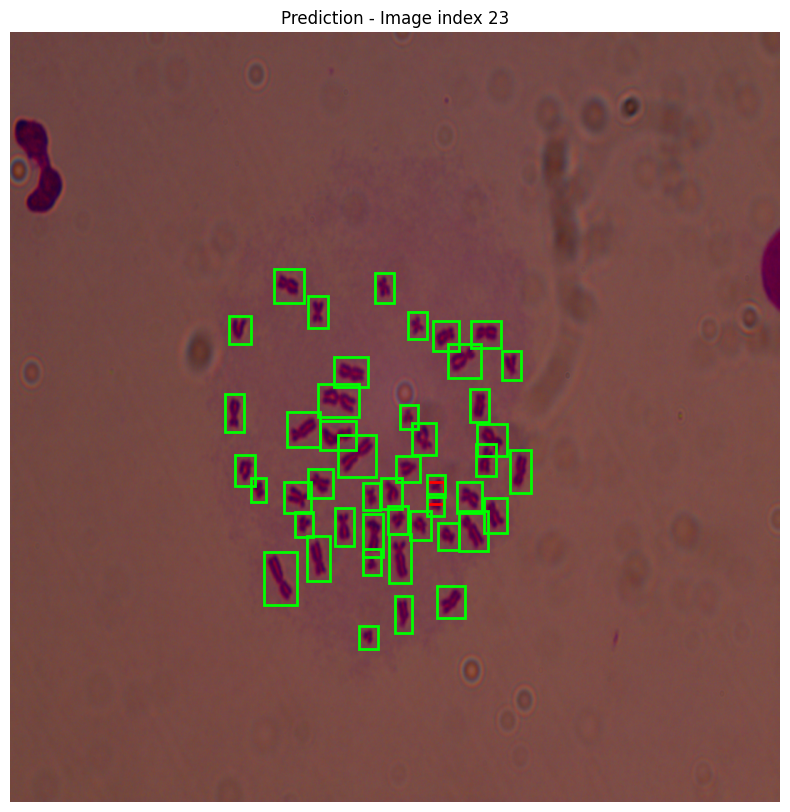

In [7]:
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision.transforms import ToTensor
from PIL import Image
import numpy as np

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = area1 + area2 - inter_area
    return inter_area / union_area if union_area > 0 else 0


def visualize_predictions_by_index(model, data_loader, index, label_map=None, score_threshold=0.5, iou_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device
    global_idx = 0

    for images, targets in data_loader:
        batch_size = len(images)
        
        if index < global_idx + batch_size:
            local_idx = index - global_idx
            img_pil = images[local_idx]
            img_tensor = ToTensor()(img_pil).unsqueeze(0).to(device)

            with torch.no_grad():
                prediction = model(img_tensor)

            pred_boxes = prediction[0]['boxes'].cpu().numpy()
            pred_scores = prediction[0]['scores'].cpu().numpy()
            pred_labels = prediction[0]['labels'].cpu().numpy()

            pred_boxes = pred_boxes[pred_scores >= score_threshold]
            pred_labels = pred_labels[pred_scores >= score_threshold]

            true_boxes = targets[local_idx]['boxes'].cpu().numpy()

            matched_pred = set()
            matched_true = set()

            for i, pb in enumerate(pred_boxes):
                for j, tb in enumerate(true_boxes):
                    iou = compute_iou(pb, tb)
                    if iou >= iou_threshold and j not in matched_true:
                        matched_pred.add(i)
                        matched_true.add(j)
                        break

            # Plot
            fig, ax = plt.subplots(1, figsize=(10, 10))
            ax.imshow(np.array(img_pil))

            # Draw predicted boxes
            for i, box in enumerate(pred_boxes):
                color = '#00FF00' if i in matched_pred else '#FF0000'  # Verde forte para TP, vermelho forte para FP
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                         linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)
            
            # Draw unmatched ground truths (False Negatives)
            for j, box in enumerate(true_boxes):
                if j not in matched_true:
                    x1, y1, x2, y2 = box
                    rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                             linewidth=1, edgecolor='#0000FF', facecolor='none')  # Azul forte
                    ax.add_patch(rect)

            ax.set_title(f"Prediction - Image index {index}")
            plt.axis('off')
            plt.show()
            return

        global_idx += batch_size

    print(f"Índice {index} fora do intervalo total do dataloader.")


index = 23
visualize_predictions_by_index(model, test_loader, index, label_map=label_map_train, score_threshold=0)

In [8]:
import torch
from torchvision.transforms import ToTensor
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
from torchvision.utils import draw_bounding_boxes
from PIL import Image
import io, zipfile
import numpy as np


def compute_iou(box1, box2):
    x1, y1 = max(box1[0], box2[0]), max(box1[1], box2[1])
    x2, y2 = min(box1[2], box2[2]), min(box1[3], box2[3])
    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter
    return inter / union if union > 0 else 0


def predict_and_save_all_colored(model, data_loader, output_zip_path, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    device = next(model.parameters()).device
    img_idx = 0
    zip_buffer = io.BytesIO()

    with zipfile.ZipFile(zip_buffer, 'w', zipfile.ZIP_DEFLATED) as zip_file:
        for batch_idx, (images, targets) in enumerate(data_loader):
            print(f"Processando batch {batch_idx + 1} com {len(images)} imagens...")

            for img, target in zip(images, targets):
                # === Prepara imagem para modelo (float32) e para desenho (uint8) ===
                tensor_img_model = ToTensor()(img).unsqueeze(0).to(device)  # float32, [0,1]
                tensor_img_draw = pil_to_tensor(img).cpu()  # uint8, [0,255]

                # === Predição ===
                with torch.no_grad():
                    prediction = model(tensor_img_model)

                pred_boxes = prediction[0]['boxes'].cpu()
                pred_scores = prediction[0]['scores'].cpu()
                pred_boxes = pred_boxes[pred_scores >= score_threshold]

                true_boxes = target['boxes'].cpu()

                matched_pred, matched_true = set(), set()
                for i, pb in enumerate(pred_boxes):
                    for j, tb in enumerate(true_boxes):
                        if compute_iou(pb, tb) >= iou_threshold and j not in matched_true:
                            matched_pred.add(i)
                            matched_true.add(j)
                            break

                # === Adiciona boxes azuis para ground-truths não encontrados ===
                boxes_to_draw = []
                colors = []

                for i, box in enumerate(pred_boxes):
                    boxes_to_draw.append(box)
                    colors.append('green' if i in matched_pred else 'red')

                for j, box in enumerate(true_boxes):
                    if j not in matched_true:
                        boxes_to_draw.append(box)
                        colors.append('blue')

                if boxes_to_draw:
                    boxes_tensor = torch.stack(boxes_to_draw)
                    drawn = draw_bounding_boxes(tensor_img_draw, boxes=boxes_tensor, colors=colors, width=2)
                else:
                    drawn = tensor_img_draw

                # === Salva imagem com caixas ===
                pil_drawn = to_pil_image(drawn)
                buf_pred = io.BytesIO()
                pil_drawn.save(buf_pred, format='PNG')
                buf_pred.seek(0)
                zip_file.writestr(f'imagens_preditas/image_{img_idx:04d}.png', buf_pred.read())

                # === Salva imagem original ===
                buf_orig = io.BytesIO()
                img.save(buf_orig, format='PNG')
                buf_orig.seek(0)
                zip_file.writestr(f'imagens_originais/image_{img_idx:04d}.png', buf_orig.read())

                # === Salva labels preditos ===
                pred_txt = "\n".join([
                    f"0 {x1:.2f} {y1:.2f} {x2 - x1:.2f} {y2 - y1:.2f}"
                    for x1, y1, x2, y2 in pred_boxes.numpy()
                ])
                zip_file.writestr(f'labels_preditas/image_{img_idx:04d}.txt', pred_txt)

                # === Salva labels reais ===
                true_txt = "\n".join([
                    f"0 {x1:.2f} {y1:.2f} {x2 - x1:.2f} {y2 - y1:.2f}"
                    for x1, y1, x2, y2 in true_boxes.numpy()
                ])
                zip_file.writestr(f'labels_reais/image_{img_idx:04d}.txt', true_txt)

                img_idx += 1

    with open(output_zip_path, 'wb') as f:
        f.write(zip_buffer.getvalue())

    print(f"\nResultados salvos em: {output_zip_path}")

# Uso:
output_zip_path = 'predictions.zip'
predict_and_save_all_colored(model, test_loader, output_zip_path, score_threshold=0.5)

Processando batch 1 com 4 imagens...
Processando batch 2 com 4 imagens...
Processando batch 3 com 4 imagens...
Processando batch 4 com 4 imagens...
Processando batch 5 com 4 imagens...
Processando batch 6 com 4 imagens...
Processando batch 7 com 4 imagens...
Processando batch 8 com 4 imagens...
Processando batch 9 com 4 imagens...
Processando batch 10 com 4 imagens...
Processando batch 11 com 4 imagens...
Processando batch 12 com 4 imagens...
Processando batch 13 com 4 imagens...
Processando batch 14 com 4 imagens...
Processando batch 15 com 4 imagens...
Processando batch 16 com 4 imagens...
Processando batch 17 com 4 imagens...
Processando batch 18 com 4 imagens...
Processando batch 19 com 4 imagens...
Processando batch 20 com 4 imagens...
Processando batch 21 com 4 imagens...
Processando batch 22 com 4 imagens...
Processando batch 23 com 4 imagens...
Processando batch 24 com 4 imagens...
Processando batch 25 com 4 imagens...
Processando batch 26 com 4 imagens...
Processando batch 27 

In [9]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.transforms import ToTensor
from torchvision.ops import box_iou

def calculate_map_and_pr(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox").to(device)

    total_tp = 0
    total_fp = 0
    total_fn = 0
    num_images_100pct = 0  # Contador para imagens com 100% de acerto

    with torch.no_grad():
        for images, targets in data_loader:
            images = [ToTensor()(img).to(device) for img in images]
            targets = [
                {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()}
                for t in targets
            ]
            predictions = model(images)
            metric.update(predictions, targets)

            for pred, target in zip(predictions, targets):
                pred_boxes = pred['boxes'].to(device).float()
                gt_boxes = target['boxes'].to(device).float()

                if pred_boxes.numel() == 0 and gt_boxes.numel() == 0:
                    # Nenhuma caixa nem predita nem real — conta como 100% correto
                    num_images_100pct += 1
                    continue
                elif pred_boxes.numel() == 0:
                    total_fn += len(gt_boxes)
                    continue
                elif gt_boxes.numel() == 0:
                    total_fp += len(pred_boxes)
                    continue

                ious = box_iou(pred_boxes, gt_boxes)
                matched_gt = set()
                matched_pred = set()

                for pred_idx in range(len(pred_boxes)):
                    for gt_idx in range(len(gt_boxes)):
                        if ious[pred_idx, gt_idx] >= iou_threshold:
                            if gt_idx not in matched_gt and pred_idx not in matched_pred:
                                matched_gt.add(gt_idx)
                                matched_pred.add(pred_idx)
                                total_tp += 1

                fp_img = len(pred_boxes) - len(matched_pred)
                fn_img = len(gt_boxes) - len(matched_gt)
                total_fp += fp_img
                total_fn += fn_img

                # Se não houver FP nem FN para essa imagem, incrementa contador
                if fp_img == 0 and fn_img == 0:
                    num_images_100pct += 1

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)

    results = metric.compute()

    print(f"\nmAP@50:     {results['map_50'].item():.4f}")
    print(f"mAP@50:95:  {results['map'].item():.4f}")
    print(f"mAR@100:    {results['mar_100'].item():.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"TP:         {total_tp}")
    print(f"FP:         {total_fp}")
    print(f"FN:         {total_fn}")
    print(f"Imagens 100% acertadas: {num_images_100pct}")

    return results, precision, recall, total_tp, total_fp, total_fn, num_images_100pct


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

map_metrics, precision, recall, tp, fp, fn, images_100pct = calculate_map_and_pr(model, test_loader, device, iou_threshold=0.5)

/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Encountered more than 100 detections in a single image. This means that certain detections with the lowest scores will be ignored, that may have an undesirable impact on performance. Please consider adjusting the `max_detection_threshold` to suit your use case. To disable this warning, set attribute class `warn_on_many_detections=False`, after initializing the metric.
  warnings.warn(*args, **kwargs)  # noqa: B028



mAP@50:     0.9624
mAP@50:95:  0.6455
mAR@100:    0.7047
Precision:  0.8532
Recall:     0.9735
TP:         5851
FP:         1007
FN:         159
Imagens 100% acertadas: 8
